### Vamos a cargar los datos

In [23]:
from arreglo_datos import vectorDatos
from transformacion import transformacion_datos
from livelossplot import PlotLosses

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.autograd import Variable

In [2]:
%load_ext autoreload
%autoreload 2

Cargamos los datos de las etiquetas.

In [3]:
path = 'C:\\Users\\masan\\Desktop\\Mario\\ESFM\\Octavo Semestre\\Servicio Social\\Etiquetas'
dic_nombre_marcas = vectorDatos(path)

In [4]:
# Vamos a extraer los datos de cada imagen para poder hacer el split de datos.
vectorDeDatos_completos = []
nombreDeImagenes = []
for key in dic_nombre_marcas.keys():
    vectorDeDatos_completos.append(dic_nombre_marcas[key])
    nombreDeImagenes.append(key)

In [5]:
# True: Con esto solo trabajamos las lineas del borde de la carretera.
modo_lineas_borde = True

if modo_lineas_borde:
    vectorDeDatos = []
    for vector in vectorDeDatos_completos:
        vector_temp = [vector[0], vector[1],  vector[-1]]
        vectorDeDatos.append(vector_temp)

#### Vamos a dividir los datos en conjunto de entrenamiento y testeo (60-40).

In [6]:
entrenamiento = int(0.8*len(vectorDeDatos))
datos_entrenamiento = vectorDeDatos[:entrenamiento]
datos_testeo = vectorDeDatos[entrenamiento:]

#### Vamos a cargar los datos con su respectiva transformación.

In [7]:
# Training
datos_transformados_training = []
for i in range(len(datos_entrenamiento)):
    try:
        sample = transformacion_datos(datos_entrenamiento[i])
        datos_transformados_training.append(sample)
    except ValueError:
        pass
    

# Testeo
datos_transformados_testeo = []
for i in range(len(datos_testeo)):
    try:
        sample = transformacion_datos(datos_testeo[i])
        datos_transformados_testeo.append(sample)
    except ValueError:
        pass
    

Vamos a hacer la funcion para graficar los puntos en las imagenes

In [132]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def graficar_lineas_target(image, puntos, color, label):
    """
    Esta funcion se encarga de graficar las lineas target
    """
    punto = np.array(puntos)
    
    x1, y1 = [punto[0][0], punto[1][0]], [punto[0][1], 20.0]
    x2, y2 = [punto[2][0], punto[3][0]], [punto[2][1], 20.0]
    #x2, y2 = [punto[2][0], punto[3][0]], [punto[2][1], punto[3][1]]
    
    plt.plot(x1, y1, x2, y2, marker='x', color=color, label=label)
    plt.legend()
    plt.imshow(np.asarray(image), cmap='gray')
    
def graficar_lineas_pred(image, puntos, color, label):
    """
    Esta funcion se encarga de graficar las lineas pred
    """
    punto = np.array(puntos)
    
    x1, y1 = [punto[0][0], punto[1][0]], [punto[0][1], 20.0]
    x2, y2 = [punto[2][0], punto[2][1]], [punto[2][1], 20.0]
    
    plt.plot(x1, y1, x2, y2, marker='x', color=color, label=label)
    plt.legend()
    plt.imshow(np.asarray(image), cmap='gray')
    

def graficar_todos_puntos(image, puntos, gt_pts=None):
    """
    Esta funcion combina las lineas pred y target
    """
    puntos = puntos.to('cpu')
    gt_pts = gt_pts.to('cpu')

    punto = np.array(puntos)

    # plot ground truth points as green pts
    if gt_pts is not None:
        gt_pts = np.array(gt_pts)

    # Aqui desplegamos las lineas que predice la red
    graficar_lineas_pred(image, punto, color='red', label='Prediction')
    
    # Aqui graficamos las lineas target
    graficar_lineas_target(image, gt_pts, color='blue', label='Target')

    plt.imshow(image, cmap='gray')
    plt.legend()

### Prueba

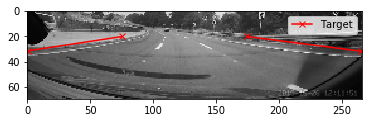

In [165]:
# Imagen aleatoria a imprimir
i = np.random.randint(0, len(datos_transformados_training))

img = datos_transformados_training[i]['image']
puntos = datos_transformados_training[i]['puntos']

graficar_lineas_target(img[0], puntos, color='red', label='Target')

In [150]:
puntos

tensor([[  0.2771,  30.2778],
        [ 90.0521,  22.5000],
        [263.7833,  33.3333],
        [161.8167,  23.6111]], dtype=torch.float64)

---

#### Cargamos la arquitectura de la red.

In [18]:
from modelo import Net
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

dropout_prob = 0.5
net = Net(dropout_prob)
net.to(device)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(7, 7), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1792, out_features=500, bias=True)
  (drop5): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=500, out_features=255, bias=True)
  (drop6): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=255, out_features=6, bias=True)
)

### Para ver la cantidad de parametros que tenemos en nuestra red -> 2,745,864

In [19]:
#print(summary(net, (1, 100, 177)))

#### Vamos a ver una muestra de los datos para ver que dimension tienen.

In [24]:
print('Number of images: ', len(datos_transformados_training))

for i in range(4):
    sample = datos_transformados_training[i]
    print(i, sample['image'].size(), sample['puntos'].size())

Number of images:  1006
0 torch.Size([1, 70, 266]) torch.Size([4, 2])
1 torch.Size([1, 70, 266]) torch.Size([4, 2])
2 torch.Size([1, 70, 266]) torch.Size([4, 2])
3 torch.Size([1, 70, 266]) torch.Size([4, 2])


#### Creamos el Train_Loader y el Test_Loader con un Batch de 50 y 5 respectivamente.

In [25]:
# Train Loader
batch_size = 50
train_loader = DataLoader(datos_transformados_training, 
                          batch_size=batch_size,
                          shuffle=True)
# Test Loader
batch_size = 5 
test_loader = DataLoader(datos_transformados_testeo, 
                          batch_size=batch_size,
                          shuffle=True)

---

### En seguida vamos a cargar una muestra con el test loader.

In [26]:
# test the model on a batch of test images
def net_sample_output():
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['puntos']

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor)
        
        # wrap them in a torch Variable
        images = Variable(images)    
        images = images.to(device)

        # forward pass to get net output
        output_pts = net(images)
        images = images.to(device)
        output_pts = output_pts.to(device)
        
        # reshape to batch_size x 28 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 3, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts

In [27]:
test_images, test_outputs, gt_pts = net_sample_output()

Vamos a graficar la salida, pero antes vamos a cargar las funciones que nos permiten visualizar la salida de nuestros datos y los que predice la CNN.

In [28]:
# visualize the output
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=5):

    for i in range(batch_size):
        plt.figure(figsize=(40,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data  # get the image from it's wrapper
        image = image.cpu()
        image = image.numpy()
        image = np.transpose(image, (1, 2, 0))
        
        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        #predicted_key_pts.cpu()
        
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts
        
        # call show_all_keypoints
        graficar_todos_puntos(np.squeeze(image), predicted_key_pts, ground_truth_pts)
        #plt.axis('off')
    plt.show()

Ahora si vamos a visualizar los puntos.

In [29]:
gt_pts[0]

tensor([[  0.8313,  31.6667],
        [ 90.8833,  21.6667],
        [252.4229,  29.4444],
        [177.0563,  20.2778]], dtype=torch.float64)

In [41]:
test_outputs[0]

tensor([[0.0000, 0.0000],
        [0.1253, 0.0000],
        [0.1824, 0.0000]], device='cuda:0', grad_fn=<SelectBackward0>)

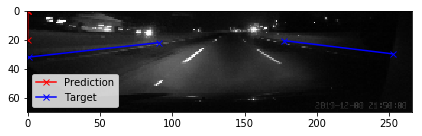

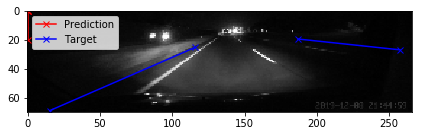

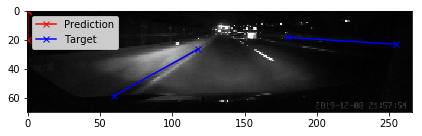

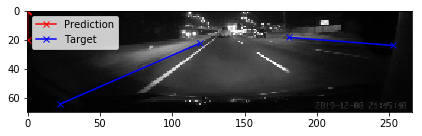

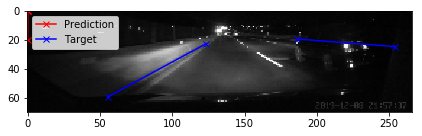

In [40]:
visualize_output(test_images, test_outputs, gt_pts)

---

Ahora ya vamos a entrenar la red.

In [42]:
## TODO: Define the loss and optimization
import torch.optim as optim

criterion = nn.L1Loss().to(device)

init_factor = 0.01
learning_rate = 0.001 * init_factor

optimizer = optim.Adam(net.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.1)

In [52]:
loss_plt = []
import datetime
def train_net(n_epochs):
    # prepare the net for training
    net.train()
    liveloss = PlotLosses()
    for epoch in range(1, n_epochs + 1):  # loop over the dataset multiple times
        #logs = {}
        scheduler.step()
        running_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['puntos']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = Variable(key_pts.type(torch.FloatTensor))
            images = Variable(images.type(torch.FloatTensor))

            #images, key_pts = Variable(images), Variable(key_pts)    
            images, key_pts = images.to(device), key_pts.to(device)
            
            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()
            
            # update the weights
            optimizer.step()

            # print loss statistics
            # to convert loss into a scalar and add it to the running_loss, use .item()
            running_loss += loss.item()
            
            #logs["Loss"] = running_loss/len(train_loader)
            
        loss_plt.append((running_loss)/len(train_loader)) 
        
        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(datetime.datetime.now(), epoch,
                    running_loss / len(train_loader)))

    print('Finished Training')

In [50]:
n_epochs = 100

In [51]:
train_net(n_epochs)

tensor([[  1.1083,  33.0556,  82.0167,  23.0556, 262.9521,  28.8889, 168.7437,
          18.6111],
        [ 44.0563,  52.2222, 113.6042,  20.0000, 265.7229,  21.3889, 207.2583,
          18.0556],
        [  0.8313,  33.3333,  72.3187,  25.0000, 264.8917,  32.7778, 168.7437,
          24.1667],
        [  0.2771,  34.1667,  82.5708,  23.3333, 265.7229,  27.7778, 167.6354,
          18.8889],
        [ 27.4312,  56.6667, 105.2917,  26.6667, 264.3375,  29.4444, 184.5375,
          20.0000],
        [ 35.7438,  52.5000, 117.7604,  19.7222, 265.1688,  20.2778, 192.0188,
          18.0556],
        [  0.0000,  28.0556,  87.5583,  18.6111, 242.4479,  43.6111, 201.9937,
          28.6111],
        [  7.7583,  31.6667,  85.6188,  19.1667, 265.7229,  26.1111, 188.1396,
          17.5000],
        [  0.5542,  30.5556,  83.4021,  23.0556, 266.0000,  31.9444, 167.9125,
          24.7222],
        [  1.6625,  26.9444,  85.0646,  23.0556, 240.5083,  56.3889, 149.9021,
          30.2778],
        [ 

C:\Users\masan\miniconda3\envs\cv-nd\lib\site-packages\torch\nn\modules\loss.py:96: UserWarning: Using a target size (torch.Size([50, 8])) that is different to the input size (torch.Size([50, 6])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (6) must match the size of tensor b (8) at non-singleton dimension 1

Vamos a imprimir el Loss para ver como es que nuestro modelo aprendio.

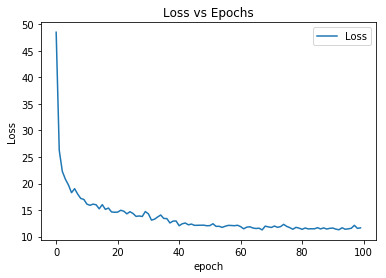

In [65]:
plt.plot(loss_plt,'-')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend(['Loss'])
plt.title('Loss vs Epochs')
plt.show()

Como podemos observar, el modelo se tiende a aplanar en la epoca 60-80.

Vamos a guardar el aprendizaje de la CNN.

In [30]:
## TODO: change the name to something uniqe for each new model
model_dir = 'saved_models/'
model_name = 'keypoints_model_100_puntos_imagenes_nuevas_corte.pt'

# after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)

---

Ahora visualizaremos los resultados.

Si queremos visualizar los datos de otro entrenamiento aqui abajo cargaremos la ruta del otro modelo.

In [45]:
load_parameters = True
if(load_parameters):
    state_dict = torch.load('saved_models/keypoints_model_100_puntos_imagenes_nuevas_corte_MSE.pt')
    net.load_state_dict(state_dict)

RuntimeError: Error(s) in loading state_dict for Net:
	size mismatch for fc3.weight: copying a param with shape torch.Size([8, 255]) from checkpoint, the shape in current model is torch.Size([6, 255]).
	size mismatch for fc3.bias: copying a param with shape torch.Size([8]) from checkpoint, the shape in current model is torch.Size([6]).

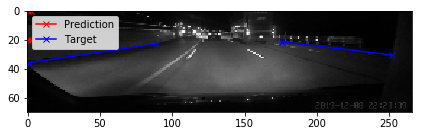

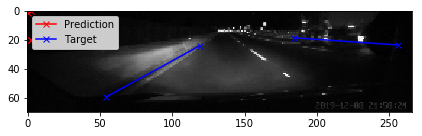

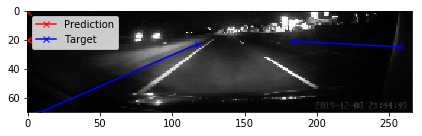

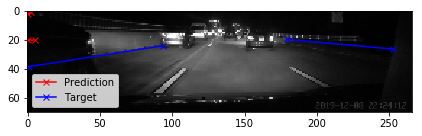

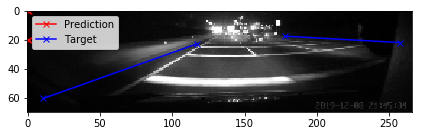

In [43]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()
visualize_output(test_images, test_outputs, gt_pts)

TODO:
 - Checar las imagenes que están mal etiquetadas
 - Ecualización del histograma  las imágenes
 - Poner linea Horizontal para solo determinar un parametro en las lineas.
 - Checar Criterion